# Gradient descent & implementation to linear regression

In this notebook I am creating from scratch (and without the use of machine learning libraries) a gradient descent algorithm, to minimize the cost function $J(\vec{w},b)$ and compute the best parameters for linear classification. 

# Libraries & tools

In [1]:
# Importing functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import copy
from sympy import var, plot_implicit

# Enable interactive plot
%matplotlib notebook

In [2]:
def animate_func(num):
    # [Optional] Auxiliar function for FuncAnimation. It's used to plot a animated
    # function to see how the cost function evolves through time
    
    # Clears the figure to update the line, point, title, and axes    
    ax.clear()  
        
    #Updating Trajectory Line (num+1 due to Python indexing)
    ax.plot(dataset[0, :num+1], dataset[1, :num+1], c='blue')    
    
    # Updating Point Location 
    ax.scatter(dataset[0, num], dataset[1, num], c='blue', marker='o')    
    
    # Adding Constant Origin
    ax.plot(dataset[0, 0], dataset[1, 0], c='black', marker='o')    
    
    # Setting Axes Limits
    #ax.set_xlim([-1, 1])
    plot_ymax = min(dataset[1, :num+1].min()*100,dataset[1, :num+1].max())
    plot_ymin = dataset[1, :num+1].min()
    plot_ydelta = plot_ymax-plot_ymin
    
    ax.set_ylim([plot_ymin-plot_ydelta*0.05,plot_ymax+plot_ydelta*0.05])

    # Adding Figure Labels
    ax.set_title('i = ' + str(int(num*len(J)/plot_points)) + ', J = ' + str(round(J[int(num*len(J)/plot_points)],3)))
    ax.set_xlabel('Iteration')
    ax.set_ylabel('J')


# Logistic regression

Linear classification is pretty similar to linear regression. One of the key differences is that our predection $f_{\vec{w},b}(\vec{x})$ is now a bit different:
$$f_{\vec{w},b}(\vec{x})=g(z)=g(\vec{w}\cdot\vec{x}+b)=\frac{1}{1+e^{-(\vec{w}\cdot\vec{x}+b)}}$$

With this definition of our prediction, there's a problem with the cost associated with the squared mean error: this function would present several local minima, and thus would not always work with gradient descent. That is why the loss is usually redefined for logistic regression.

$$L(f_{\vec{w},b}(\vec{x}^{(i)}),y^{(i)})=(-y^{(i)} \log (f_{ \vec{w},b}(\vec{x}^{(i)}))-(1-y^{(i)})\log(1-f_{\vec{w},b}(\vec{x}^{(i)}))$$

With this new definition of the loss function, the resulting cost function has a smooth behaviour and its equal to 

$$\begin{equation*}\begin{split}J (\vec{w},b) = -\frac{1}{m} \sum_{i=1}^m [y^{(i)}\log(f_{\vec{w},b}(\vec{x}^{(i)}))+(1-y^{(i)})\log(1-f_{\vec{w},b}(\vec{x}^{(i)}))] \end{split} \end{equation*}$$

In [3]:
def compute_prediction(X,w,b):
    z = np.matmul(X,w)+b
    f = 1/(1+np.exp(-z))
    return f

In [4]:
# We need to be careful when x is zero because the logarithm diverges.
# We can avoid this by adding a small value to x when x is zero.
def compute_cost(X,y,w,b):
    epsilon = 1e-35
    f = compute_prediction(X,w,b)
    loss = np.array([yy*np.log(ff)+(1-yy)*np.log(1-ff) if ~((ff==0)|(ff==1)) else yy*np.log(ff+epsilon)+(1-yy)*np.log(1-ff+epsilon) for ff,yy in zip(f,y)])
    return -np.sum(loss)

We can then compute the gradient using the same formula (although $f$ now has a different form)
$$ \frac{\partial J}{\partial w_j} = \sum_{i=1}^{m}(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})x_j^{(i)}$$
$$ \frac{\partial J}{\partial b} =\sum_{i=1}^{m}(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})$$

In [5]:
def compute_gradient(X,y,w,b):
    #Vectorized formula to compute the gradients
    f = compute_prediction(X,w,b)
    
    dj_dw = np.matmul(X.T,f-y)
    dj_db = np.sum(f-y)
    return dj_dw, dj_db

Now we apply gradient descent, which is a constant iteration where we update the parameters in the opposite direction of the gradient, i.e. $$w_j \rightarrow w_j-\alpha\frac{1}{m}\sum_{i=1}^{m}(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})x_j^{(i)}$$
$$b \rightarrow b-\alpha\frac{1}{m}\sum_{i=1}^{m}(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})$$

In [6]:
def gradient_descent(X,y,w,b,alpha,iterations,visual=False,points=None, lambda_=0):
    m = X.shape[0]
    
    if visual == False:
    # Gradient_descent with NO visualization
    
        # Algorithm
        for i in range(iterations):
            dj_dw, dj_db = compute_gradient(X,y,w,b)
        
            w = w*[1-alpha*lambda_/m] - alpha*dj_dw/m
            b -= alpha*dj_db/m
            
            # Print the process if asked
            try:
                if (i%points==0):
                    print(f"J(i) reached a value of {compute_cost(X,y,w,b):.3f} at {i}.")
            except TypeError:
                pass
            
            
        print(f"The solution found is w = {w.reshape(1,-1).round(2)}, b = {b:.2f}. Final cost = {compute_cost(X,y,w,b):.2f}.")    
    
    else:
    # Gradient_descent WITH visualization
        global line_ani, ax, dataset, J, plot_points # Neccessary for animated visualization
        plot_points = 100 if points is None else points
        
        J = np.zeros(iterations+1)
        J[0] = compute_cost(X,y,w,b)
        for i in range(iterations):
            dj_dw, dj_db = compute_gradient(X,y,w,b)
        
            w = w*[1-alpha*lambda_/m] - alpha*dj_dw/m
            b -= alpha*dj_db/m
            
            J[i+1] = compute_cost(X,y,w,b)
     
        print(f"The solution found is w = {w.reshape(1,-1).round(2)}, b = {b:.2f}. Final cost = {compute_cost(X,y,w,b):.2f}.")    
    
        # Setting up Data Set for Animation
        J_len = int(len(J)/plot_points)
        J_plot = list(J[0:-1:J_len])
        dataset = np.array([np.array(range(0,iterations,J_len)), J_plot])  # Combining our position coordinates
        numDataPoints = len(J)

        # Plotting the Animation
        fig = plt.figure(figsize=(9.5,6), dpi= 100)
        fig.suptitle('Evolution of the Cost Function $J(i)$ through each iteration.')
        ax = plt.subplot(1,2,1)
        line_ani = animation.FuncAnimation(fig, animate_func, interval=100,   
                                           frames=numDataPoints,blit=True,repeat=False)

        threshold = int(iterations/10)
        ax2 = plt.subplot(1,2,2)
        ax2.plot(range(len(J)-threshold,len(J)), J[-threshold:], c='blue')     
        ax2.set_title(f"Last {threshold} iterations.",y=1.03)        
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('J')        
        plt.show()
    
    return w,b

# TEST EXAMPLES

## Example 1

In [7]:
# Generate dataset
n_points = 100
np.random.seed(6)
X1 = np.random.normal(loc=4,scale=1.2,size=(2,n_points)).T
X2 = np.random.normal(loc=1,scale=1.2,size=(2,n_points)).T
y1 = np.ones(n_points)
y2 = np.zeros(n_points)

X = np.r_[X1,X2]
y = np.r_[y1,y2].reshape(-1,1)

The solution found is w = [[1.72 1.91]], b = -9.21. Final cost = 24.21.


<IPython.core.display.Javascript object>


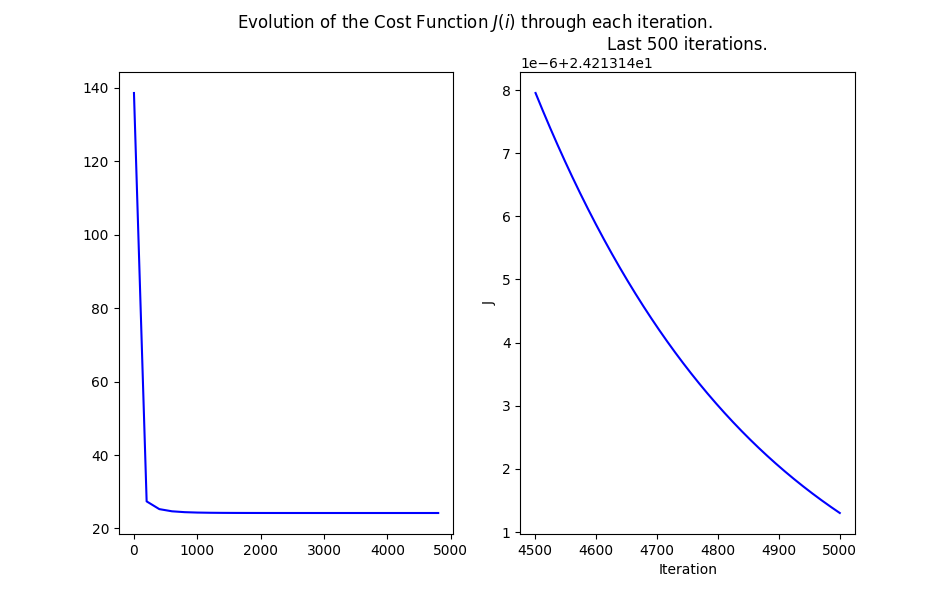

<IPython.core.display.Javascript object>


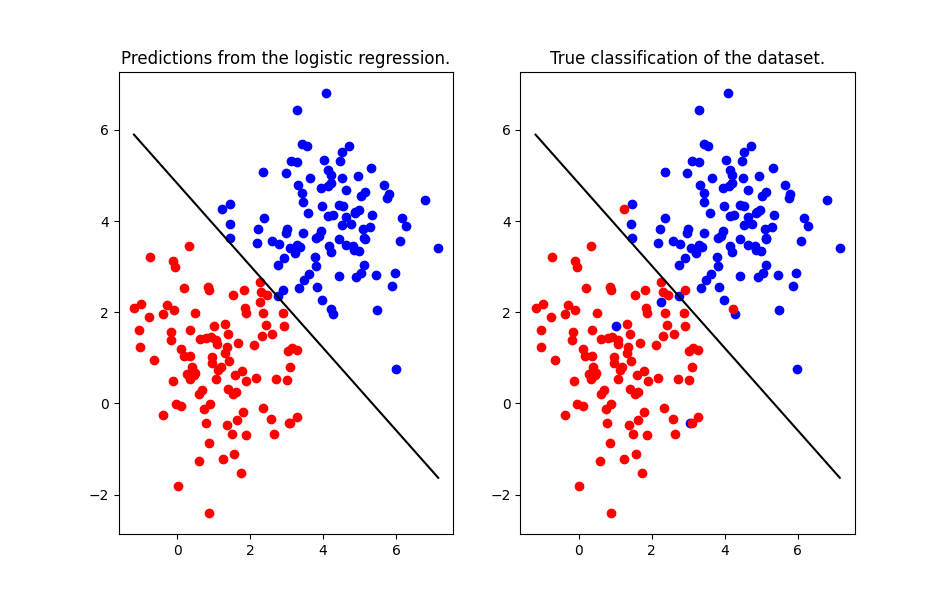

In [8]:
# Initial conditions for the Gradient descent
w = np.array([0.,0.]).reshape(-1,1)
b = 0

# CALLING THE FUNCTION
w,b = gradient_descent(X,y,w,b,8e-1,5000,visual=True,points=25)



# Computing and plotting prediction
pred = compute_prediction(X,w,b)
pred = np.array([1 if element > 0.5 else 0 for element in pred])

plt.figure(figsize=(9.5,6), dpi= 100)
axx = plt.subplot(1,2,1)
axx.set_title(f"Predictions made by my trained logistic regression.")

plt.scatter(X[pred==1,0],X[pred==1,1],color='blue')
plt.scatter(X[pred==0,0],X[pred==0,1],color='red')

# plotting the decision boundary z = 0
plt.title('Predictions from the logistic regression.')
xx1 = np.linspace(min(X[:,0]),max(X[:,0]),num=100)
xx2=(-xx1*w[0]-b)/w[1]
plt.plot(xx1,xx2,color='black')
plt.plot()
plt.show()

axx2 = plt.subplot(1,2,2)
axx2.set_title(f"True classification of the dataset.")
plt.scatter(X1[:,0],X1[:,1],color='blue')
plt.scatter(X2[:,0],X2[:,1],color='red')
plt.plot(xx1,xx2,color='black')
plt.show()

## Example 2.

In this example, we have one small cluster within a big one. This is not compatible with the previous linear logistic regression we did in example 1. However, with a small addition of variables (quadratic terms) to our matrix $X$, the method will work perfectly and find the best parameters for the curve. 

In [9]:
# Generate dataset
n_points = 100
np.random.seed(9)
X1 = np.random.normal(loc=3,scale=0.2,size=(2,n_points)).T
X2 = np.random.normal(loc=3,scale=2,size=(2,n_points)).T
y1 = np.ones(n_points)
y2 = np.zeros(n_points)

X = np.r_[X1,X2]

X = np.c_[X,X**2,X[:,0]*X[:,1]]
y = np.r_[y1,y2].reshape(-1,1)

The solution found is w = [[ 6.42  6.75 -7.04 -7.09 11.74]], b = -14.20. Final cost = 18.15.


<IPython.core.display.Javascript object>


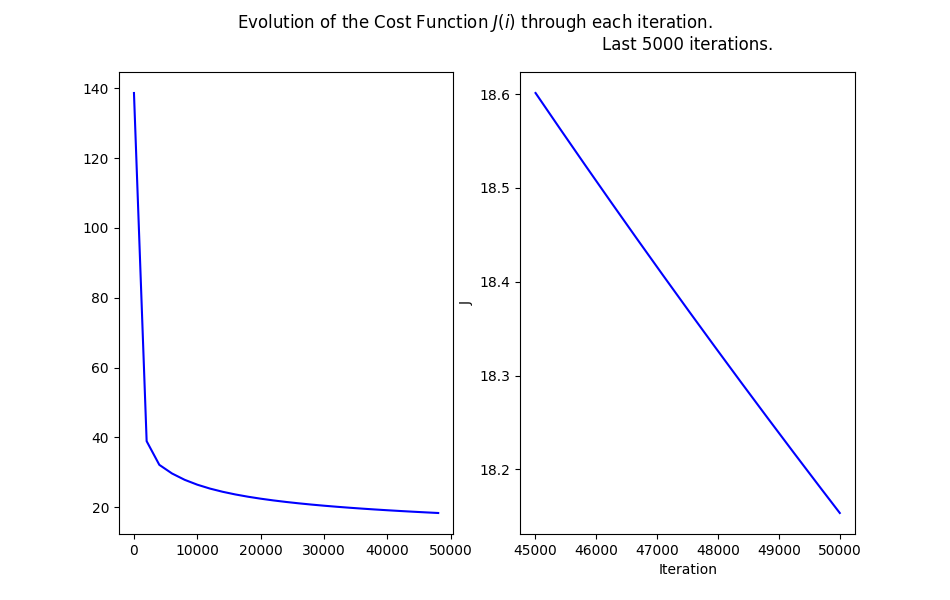

<IPython.core.display.Javascript object>


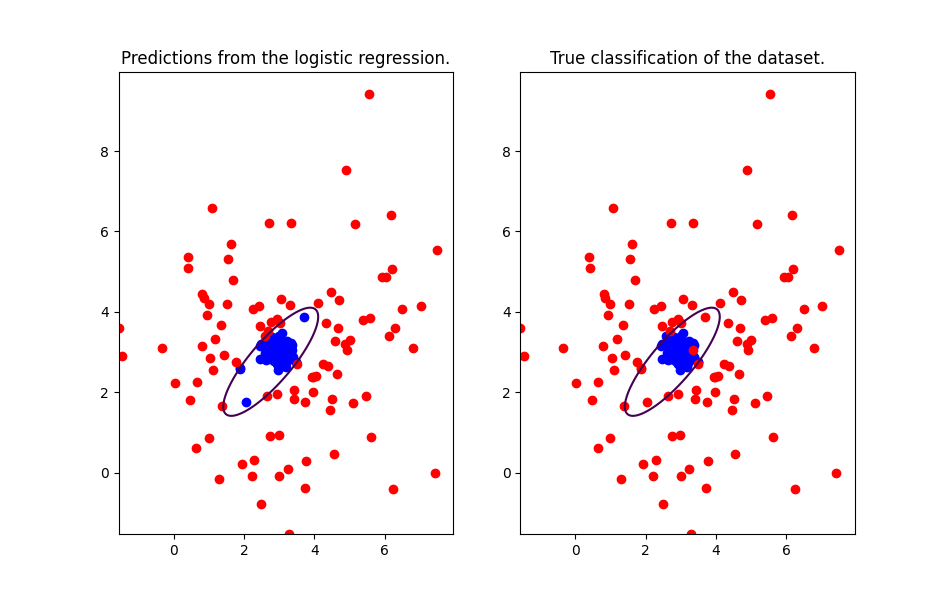

In [10]:
# Initial conditions for the Gradient descent
w = np.zeros(X.shape[1]).reshape(-1,1)
b = 0

# CALLING THE FUNCTION
w,b = gradient_descent(X,y,w,b,9e-2,50000,visual=True,points=25)

# Computing and plotting prediction
pred = compute_prediction(X,w,b)
pred = np.array([1 if element > 0.5 else 0 for element in pred])

plt.figure(figsize=(9.5,6), dpi = 100)
axx = plt.subplot(1,2,1)
axx.set_title(f"Predictions from the logistic regression.")

plt.scatter(X[pred==1,0],X[pred==1,1],color='blue')
plt.scatter(X[pred==0,0],X[pred==0,1],color='red')

# Plotting decision boundary
delta = 0.025
xrange = np.arange(min(X[:,0]),max(X[:,0]), delta)
yrange = np.arange(min(X[:,1]),max(X[:,1]), delta)
vx, vy = np.meshgrid(xrange,yrange)
F = vx*w[0][0]+vy*w[1][0]+vx**2*w[2][0]+vy**2*w[3][0]+vx*vy*w[4][0]+b
G = 0
plt.contour(vx, vy, (F - G), [0])


# Real dataset
axx2 = plt.subplot(1,2,2)
axx2.set_title(f"True classification of the dataset.")
plt.scatter(X1[:,0],X1[:,1],color='blue')
plt.scatter(X2[:,0],X2[:,1],color='red')

# Plotting decision boundary
delta = 0.025
xrange = np.arange(min(X[:,0]),max(X[:,0]), delta)
yrange = np.arange(min(X[:,1]),max(X[:,1]), delta)
vx, vy = np.meshgrid(xrange,yrange)

# F is one side of the equation, G is the other
F = vx*w[0][0]+vy*w[1][0]+vx**2*w[2][0]+vy**2*w[3][0]+vx*vy*w[4][0]+b
G = 0

plt.contour(vx, vy, (F - G), [0])

plt.show()

In this example we added quadratic terms, though we could've added terms of a higher polynomial degree. Of course, this would also increase the chances of overfitting, so regularization should be applied.